In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import random
import numba
import statsmodels.api as sm
from sklearn.metrics import r2_score
import pandas as pd
import os
import sys
import glob

# Step 1: Add parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "/scratch/ivyglade/pdo/"))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Step 2: Now you can import file.py
import pdo_functions  # assuming file.py contains functions/classes

import importlib
importlib.reload(pdo_functions)

<module 'pdo_functions' from '/scratch/ivyglade/pdo/pdo_functions.py'>

In [2]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1870, 2024)

oni = pdo_functions.oni_moving_base(sst)

In [18]:
sst_fill = xr.where(sst < -1.8, -1.8, sst)

In [39]:
sst_fill_anoms = sst_fill.groupby('time.month') - sst_fill.groupby('time.month').mean()

In [30]:
# Land mask
land_110 = regionmask.defined_regions.natural_earth_v4_1_0.land_110
land = xr.where(land_110.mask_3D(sst, lon_name='longitude', lat_name='latitude')==True, np.nan, 1).squeeze()

/scratch/ivyglade/miniconda3/envs/myenv_py39/lib/python3.9/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


In [40]:
# mask out land
sst_fill_no_land = sst_fill_anoms*land

In [36]:
# detrend dimension
sst_fill_no_land_de = pdo_functions.detrend_dim(sst_fill_no_land, 'time', 2)

In [57]:
spatial_pdo = pdo_functions.linregress_3D(pdo.values, sst_fill_no_land_de.values)[2]

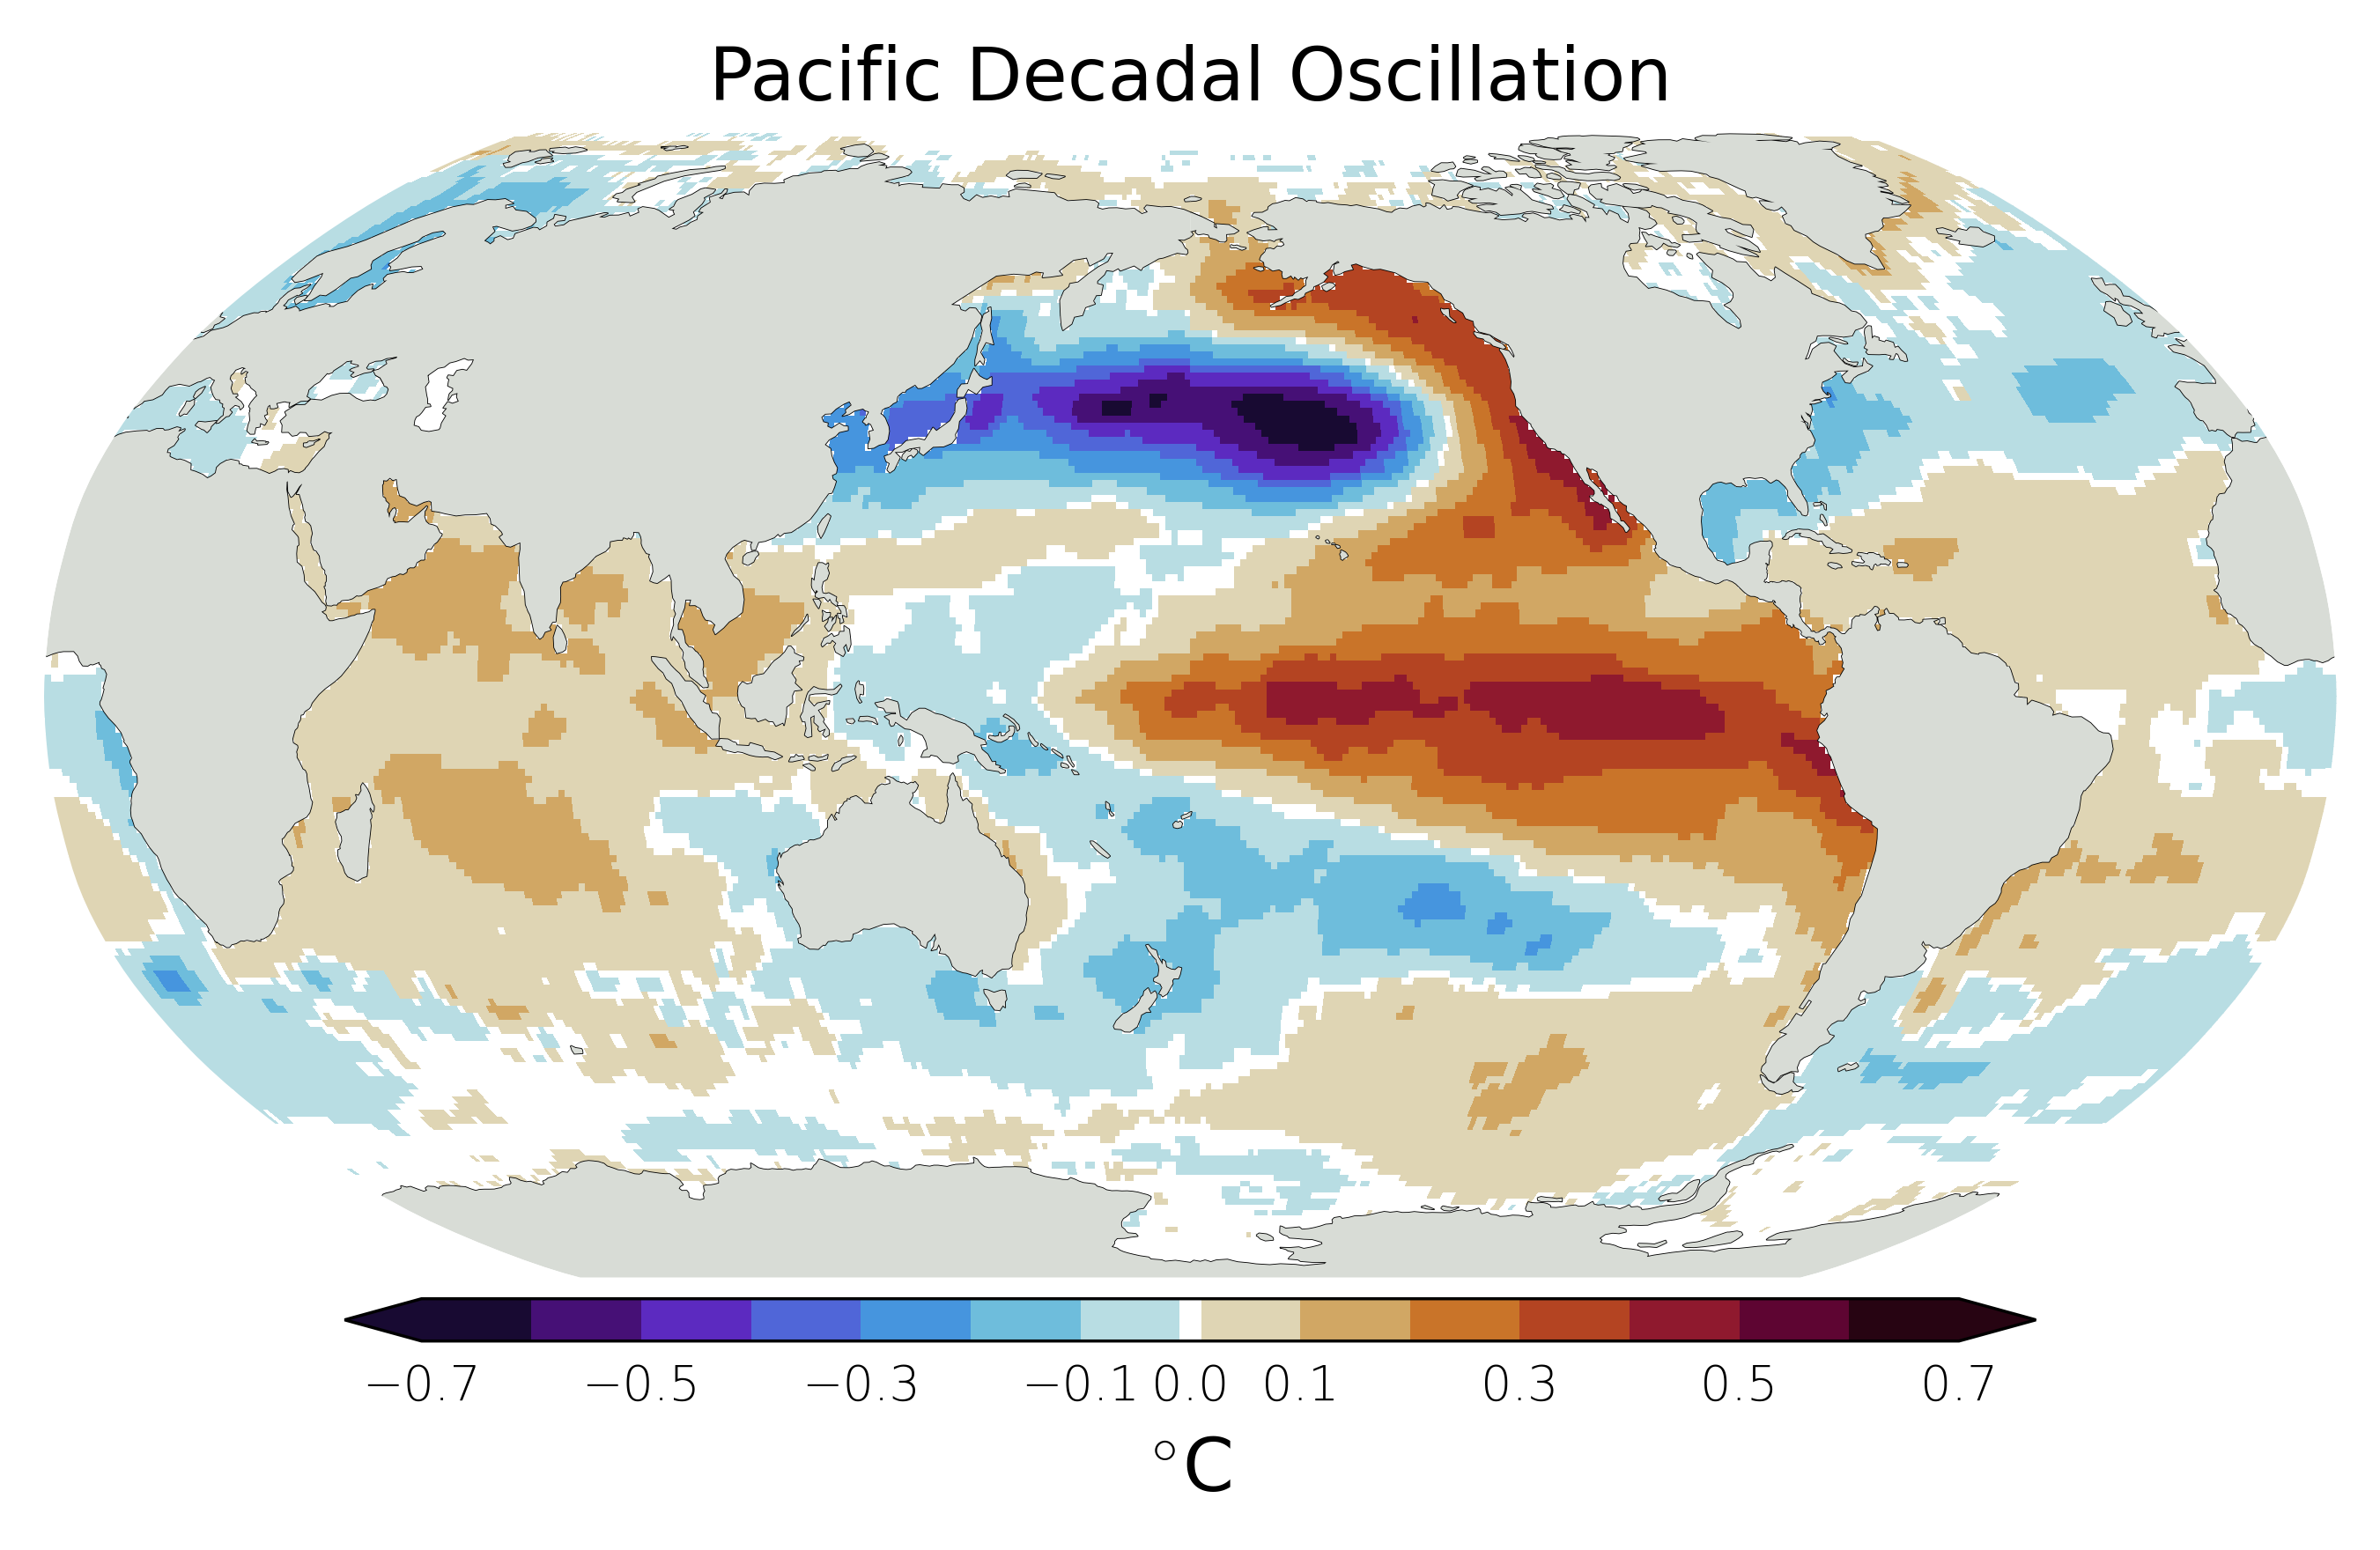

In [58]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

bounds = [-0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, -0.01, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

ax.coastlines(lw=0.25, edgecolor='xkcd:gunmetal')
ax.spines['geo'].set_linewidth(0)
ax.add_feature(ct.feature.LAND, facecolor='xkcd:light gray', zorder=100)

ax.pcolormesh(sst['longitude'], sst['latitude'], spatial_pdo, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

ax.set_title('Pacific Decadal Oscillation', pad=0)

cax = plt.axes([0.2, .22, 0.6, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', ticks=[-0.7, -0.5, -0.3, -0.1, 0, 0.1, 0.3, 0.5, 0.7])
cbar.set_label(r'$^{\circ}$C', size=12, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=8, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.8, 
                    wspace=0.05, 
                    hspace=0.05)